In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [64]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [65]:
labels_pd.head()
counts_pd.head()

,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


In [66]:
#merge two tables together
labels_and_counts = pd.merge(labels_pd, counts_pd, left_on='index', right_on='Unnamed: 0')
labels_and_counts

,index,bulk_labels,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,Dendritic,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,CD56+ NK,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,Dendritic,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,TGGCACCTCCAACA-8,Dendritic,TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,...,1.576,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593
696,TGTGAGTGCTTTAC-8,Dendritic,TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,...,-1.136,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490
697,TGTTACTGGCGATT-8,CD4+/CD25 T Reg,TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,...,-0.381,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226
698,TTCAGTACCGGGAA-8,CD19+ B,TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,...,-1.136,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490


In [67]:
#label encode the cells
labels_and_counts['label'] = labels_and_counts['bulk_labels'].astype('category').cat.codes
labels_and_counts
#shuffle the table
labels_and_counts_shuffled = labels_and_counts.iloc[:, 3:].sample(frac=1).reset_index(drop=True)#.drop('Unnamed: 0', axis=1)
labels_and_counts_shuffled

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,label
0,-0.326,-0.191,2.120,0.394,-0.174,-0.531,1.737,-0.486,-0.459,-0.525,...,-0.532,-0.341,0.167,-1.080,-0.585,-0.341,-0.210,-0.636,-0.490,3
1,-0.326,-0.191,-0.728,0.232,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-1.080,-0.585,0.205,-0.210,-0.636,-0.490,3
2,-0.326,-0.191,1.679,0.147,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-1.080,-0.585,-0.447,-0.210,-0.636,-0.490,9
3,-0.326,-0.191,-0.728,-0.623,-0.174,-0.531,-0.451,-0.486,-0.459,4.259,...,-0.532,-0.341,-0.129,-0.017,1.503,-0.034,-0.210,-0.636,-0.490,9
4,0.975,-0.191,-0.728,2.505,-0.174,0.721,1.583,1.107,-0.459,-0.525,...,-0.532,2.185,-0.905,-0.397,0.756,2.795,-0.210,-0.636,1.366,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-0.326,-0.191,-0.728,-0.568,-0.174,1.604,-0.451,0.872,-0.459,0.785,...,-0.532,-0.341,-0.905,0.667,0.558,0.603,-0.210,-0.636,1.092,9
696,-0.326,-0.191,-0.728,-0.526,-0.174,-0.531,-0.451,0.963,-0.459,-0.525,...,-0.532,-0.341,0.001,-1.080,-0.585,1.870,1.149,-0.636,-0.490,9
697,-0.326,-0.191,-0.198,0.283,-0.174,1.473,0.363,-0.486,-0.459,-0.525,...,0.154,-0.341,-0.108,-0.533,1.561,-1.026,-0.210,-0.636,-0.490,1
698,-0.326,-0.191,0.397,-1.200,-0.174,-0.531,-0.451,-0.486,0.779,0.780,...,-0.532,1.806,-0.058,-1.080,-0.585,0.056,-0.210,-0.636,-0.490,9


Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [68]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch

# taking out X and y as numpy arrays

X = labels_and_counts_shuffled.drop('label', axis=1).to_numpy(dtype=np.float32)
y = labels_and_counts_shuffled['label']              .to_numpy(dtype=np.int64)

# do an 80/20 split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split( X, y,test_size=0.2,shuffle=True,random_state=42)

#  numpy arrays to tensors
X_train = torch.from_numpy(X_train_np)
X_test  = torch.from_numpy(X_test_np)
Y_train = torch.from_numpy(y_train_np)
Y_test  = torch.from_numpy(y_test_np)

In [69]:
y

array([3, 3, 9, 9, 0, 0, 6, 1, 0, 9, 0, 9, 8, 8, 5, 1, 9, 9, 6, 3, 1, 3,
       9, 0, 9, 0, 8, 9, 8, 6, 9, 1, 9, 5, 9, 0, 6, 7, 9, 1, 9, 2, 0, 0,
       7, 9, 7, 7, 1, 1, 0, 9, 9, 1, 3, 1, 9, 1, 9, 0, 5, 9, 3, 7, 9, 9,
       9, 3, 5, 3, 0, 0, 0, 0, 0, 1, 9, 7, 9, 9, 3, 0, 9, 8, 5, 8, 0, 9,
       0, 0, 9, 0, 2, 9, 4, 2, 1, 0, 9, 7, 9, 0, 9, 7, 9, 9, 9, 9, 9, 9,
       9, 0, 6, 8, 9, 3, 3, 1, 0, 3, 9, 9, 1, 8, 0, 7, 0, 6, 0, 1, 1, 9,
       9, 0, 0, 3, 9, 1, 9, 0, 8, 1, 1, 9, 0, 7, 1, 6, 7, 9, 9, 7, 6, 6,
       6, 2, 3, 9, 8, 2, 0, 9, 9, 0, 0, 9, 0, 4, 1, 9, 7, 5, 9, 9, 1, 6,
       3, 3, 3, 3, 0, 9, 0, 3, 1, 1, 9, 6, 3, 9, 3, 6, 9, 9, 0, 9, 0, 7,
       9, 3, 5, 7, 9, 9, 3, 9, 9, 0, 9, 3, 5, 1, 9, 9, 9, 9, 8, 9, 9, 1,
       0, 3, 9, 5, 0, 8, 9, 2, 1, 2, 9, 5, 0, 1, 8, 9, 6, 3, 7, 7, 7, 0,
       3, 0, 6, 9, 3, 9, 9, 9, 9, 0, 9, 7, 8, 9, 4, 1, 9, 9, 0, 2, 9, 0,
       0, 7, 1, 9, 0, 3, 9, 0, 8, 9, 3, 9, 9, 5, 3, 9, 2, 9, 9, 9, 0, 9,
       3, 0, 9, 1, 9, 0, 9, 9, 7, 1, 9, 0, 7, 6, 9,

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [70]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, use_batchnorm=False):
        super().__init__()
        layers = [
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        ]
        self.encoder = nn.Sequential(*layers)
        dec_layers = [
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        ]
        self.decoder = nn.Sequential(*dec_layers)
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)
    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent


Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

## implement k-fold, go through the latent dimension sizes go from like 15 to 256 , try some different number for latent sparsity, I should try batch normalization between layers, I could also try L2 regularization with L1 worst case.

In [71]:
from sklearn.model_selection import KFold
import numpy as np
import copy

def train_autoencoder(
    X, latent_dim, l1_lambda=0, use_batchnorm=False,
    n_epochs=100, patience=10, batch_size=64, verbose=False
):
    # 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses = []

    for train_idx, val_idx in kf.split(X):
        #split up data for this fold
        X_train_fold = torch.from_numpy(X[train_idx]).float()
        X_val_fold = torch.from_numpy(X[val_idx]).float()
        #create new model for each fold
        model = Autoencoder(X.shape[1], latent_dim, use_batchnorm=use_batchnorm)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        mse_loss = nn.MSELoss()

        best_val_loss = np.inf
        patience_counter = 0 #counter for early stopping
        best_model = None

        for epoch in range(n_epochs):
            # train
            model.train()
            permutation = torch.randperm(X_train_fold.size(0))
            for i in range(0, X_train_fold.size(0), batch_size):
                idx = permutation[i:i+batch_size]
                xb = X_train_fold[idx]
                optimizer.zero_grad()
                reconstructed, latent = model(xb)
                loss = mse_loss(reconstructed, xb)
                l1_loss = l1_lambda * torch.mean(torch.abs(latent))
                total = loss + l1_loss
                total.backward()
                optimizer.step()

            # validation data
            model.eval()
            with torch.no_grad():
                val_recon, val_latent = model(X_val_fold)
                val_loss = mse_loss(val_recon, X_val_fold) + l1_lambda * torch.mean(torch.abs(val_latent))

            #save the best validation loss data
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
                best_model = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break
        val_losses.append(best_val_loss)

    return np.mean(val_losses), best_model  # average val loss, weights

In [72]:
latent_dims = [15, 32, 64]
l1_lambdas = [0, 1e-6, 1e-5, 1e-4]
batchnorm_options = [False, True]

results = []
X_np = X_train_np  # (input matrix as np.array)

for latent_dim in latent_dims:
    for l1 in l1_lambdas:
        for bn in batchnorm_options:
            avg_val_loss, model_weights = train_autoencoder(
                X_np, latent_dim, l1_lambda=l1, use_batchnorm=bn, n_epochs=80, patience=6
            )
            results.append({
                "latent_dim": latent_dim, "l1": l1, "batchnorm": bn,
                "val_loss": avg_val_loss, "model_weights": model_weights
            })
            print(f"latent_dim={latent_dim}, l1={l1}, batchnorm={bn} val_loss={avg_val_loss:.4f}")


latent_dim=15, l1=0, batchnorm=False val_loss=0.8614
latent_dim=15, l1=0, batchnorm=True val_loss=0.8731
latent_dim=15, l1=1e-06, batchnorm=False val_loss=0.8611
latent_dim=15, l1=1e-06, batchnorm=True val_loss=0.8730
latent_dim=15, l1=1e-05, batchnorm=False val_loss=0.8609
latent_dim=15, l1=1e-05, batchnorm=True val_loss=0.8737
latent_dim=15, l1=0.0001, batchnorm=False val_loss=0.8605
latent_dim=15, l1=0.0001, batchnorm=True val_loss=0.8728
latent_dim=32, l1=0, batchnorm=False val_loss=0.8579
latent_dim=32, l1=0, batchnorm=True val_loss=0.8773
latent_dim=32, l1=1e-06, batchnorm=False val_loss=0.8582
latent_dim=32, l1=1e-06, batchnorm=True val_loss=0.8750
latent_dim=32, l1=1e-05, batchnorm=False val_loss=0.8582
latent_dim=32, l1=1e-05, batchnorm=True val_loss=0.8763
latent_dim=32, l1=0.0001, batchnorm=False val_loss=0.8577
latent_dim=32, l1=0.0001, batchnorm=True val_loss=0.8770
latent_dim=64, l1=0, batchnorm=False val_loss=0.8559
latent_dim=64, l1=0, batchnorm=True val_loss=0.8770
lat

#keep latent dimension as 64 as the max, 32 is also good

In [83]:
#find the model with the best loss
best = min(results, key=lambda x: x["val_loss"])
print("Best config:", best)
best_model = Autoencoder(X_np.shape[1], best['latent_dim'], use_batchnorm=best['batchnorm'])
best_model.load_state_dict(best['model_weights'])
torch.save(best_model.state_dict(), 'best_autoencoder.pt')


Best config: {'latent_dim': 64, 'l1': 1e-06, 'batchnorm': False, 'val_loss': np.float64(0.854588258266449), 'model_weights': OrderedDict([('encoder.0.weight', tensor([[-0.0335, -0.0430, -0.0065,  ...,  0.0219, -0.0107, -0.0094],
        [ 0.0069,  0.0082,  0.0114,  ...,  0.0427, -0.0250, -0.0249],
        [ 0.0707,  0.0072,  0.0797,  ...,  0.0266,  0.0414, -0.0180],
        ...,
        [ 0.0241,  0.0171, -0.0179,  ..., -0.0135,  0.0201, -0.0546],
        [-0.0696, -0.0323, -0.0161,  ..., -0.0093, -0.0179,  0.0288],
        [ 0.0054,  0.0186, -0.0287,  ..., -0.0250,  0.0257, -0.0365]])), ('encoder.0.bias', tensor([ 0.0340,  0.0137,  0.0407,  0.0486,  0.0592,  0.0229,  0.0624,  0.0057,
         0.0431,  0.0194,  0.0245,  0.0094,  0.0214,  0.0049,  0.0416,  0.0362,
         0.0087,  0.0409,  0.0122,  0.0673,  0.0648,  0.0029,  0.0436,  0.0541,
         0.0169,  0.0265,  0.0588, -0.0067,  0.0242,  0.0508,  0.0742,  0.0079,
         0.0450,  0.0273,  0.0483,  0.0896,  0.0148,  0.0815,  0.0

In [84]:
import torch.nn as nn

X_test_tensor = torch.from_numpy(X_test_np).float()

best_model.eval()
mse_loss = nn.MSELoss()

with torch.no_grad():
    reconstructed, latent = best_model(X_test_tensor)
    test_loss = mse_loss(reconstructed, X_test_tensor).item()

print(f"Test MSE loss: {test_loss:.4f}")


Test MSE loss: 0.8392


In [85]:
best_model.eval()
with torch.no_grad():
    latent_all = best_model.encode(torch.from_numpy(X_np).float()).numpy()


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
y = Y_train

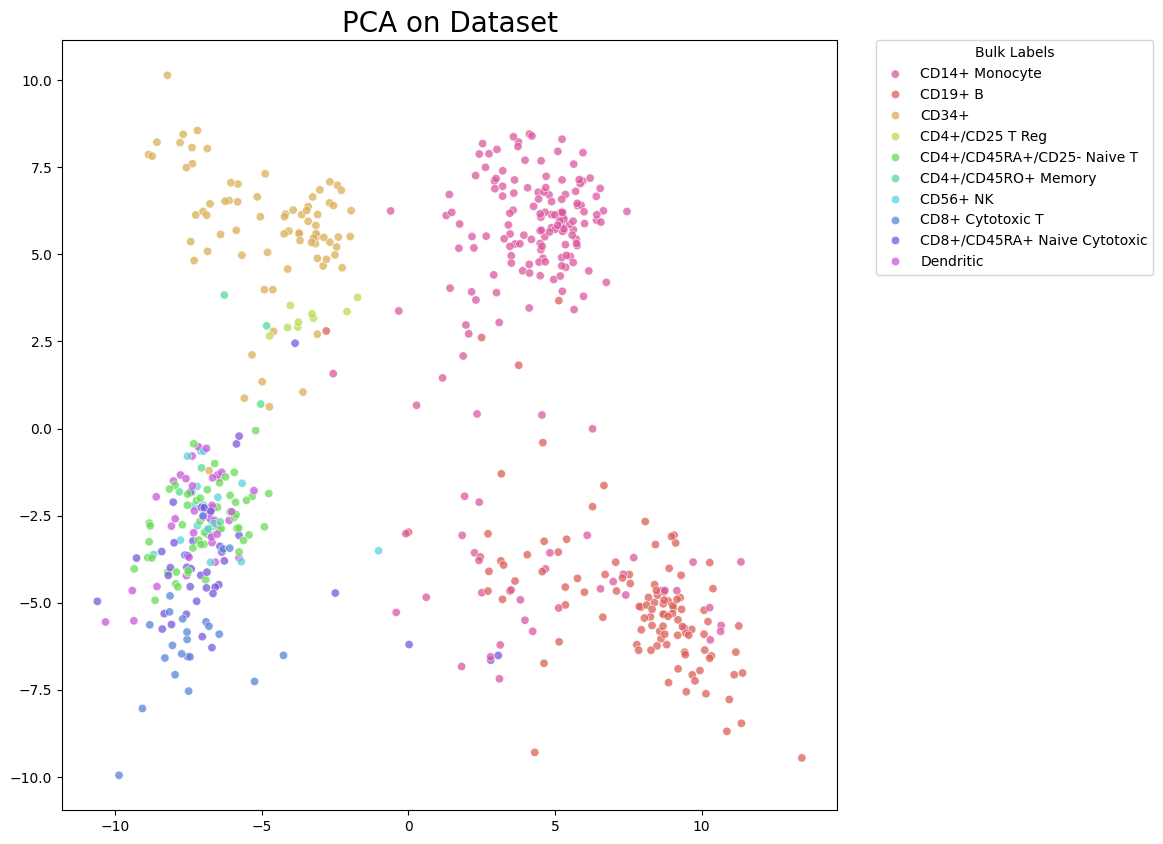

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

bulk_labels = ['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK', 'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic']


plt.figure(figsize=(10,10))
scatter = sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

handles, labels = scatter.get_legend_handles_labels()
plt.title('PCA on Dataset', fontsize=20)
plt.legend(title='Bulk Labels', labels=bulk_labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.savefig('/content/pca.png', dpi=300, bbox_inches='tight')

plt.show()

###Apply tsne

In [88]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components= 2)
X_tsne = tsne.fit_transform(X_train)
y = Y_train

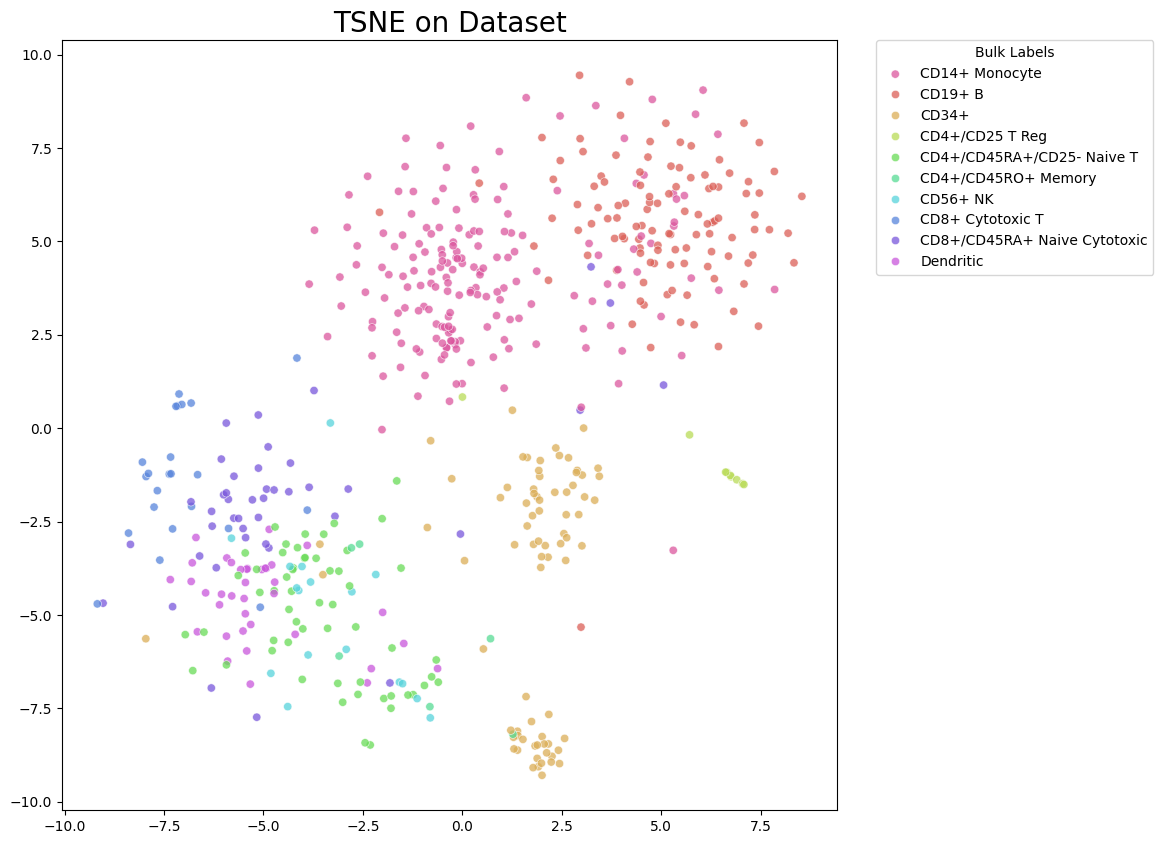

In [89]:

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)

handles, labels = scatter.get_legend_handles_labels()
plt.title('TSNE on Dataset', fontsize=20)
plt.legend(title='Bulk Labels', labels=bulk_labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.savefig('/content/tsne.png', dpi=300, bbox_inches='tight')
plt.show()

###pca on latent features  

#### standardizing the features

In [90]:
with torch.no_grad():
    latent_all = best_model.encode(torch.from_numpy(X_np).float()).numpy()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
latent_all_scaled = scaler.fit_transform(latent_all)
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_all_scaled)


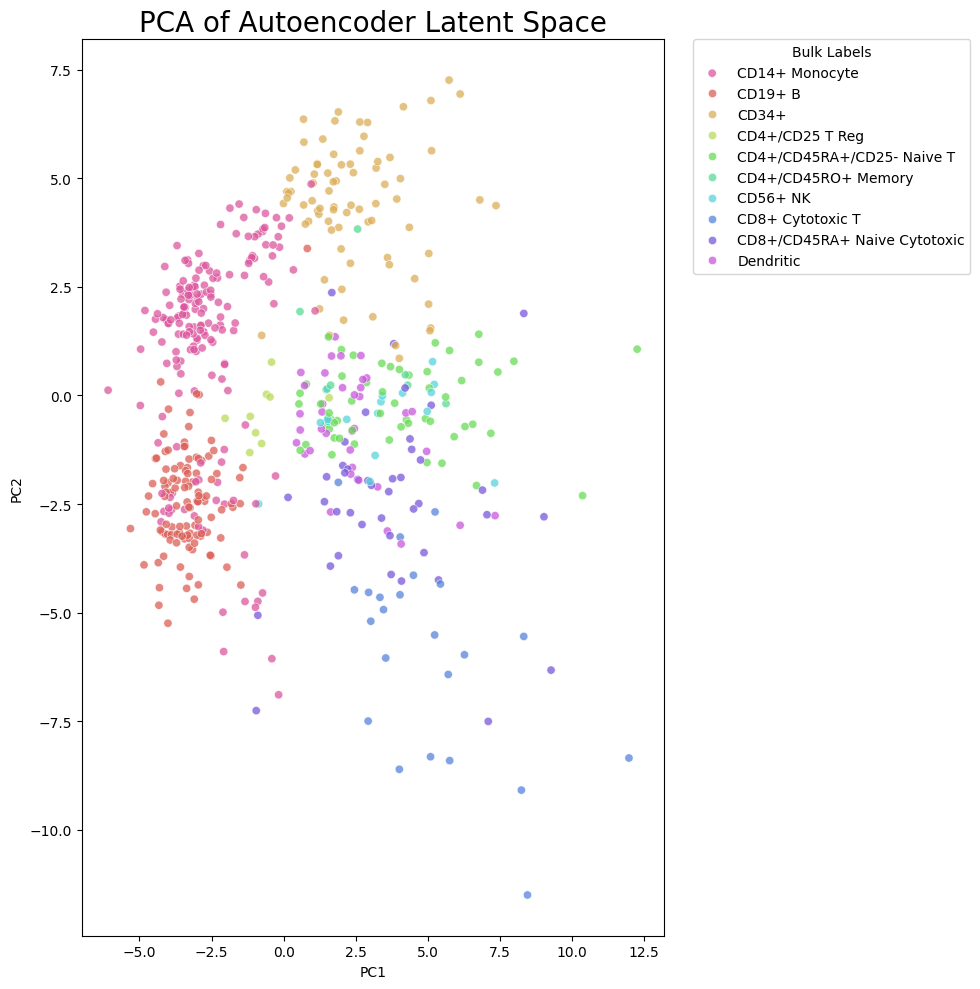

In [91]:

# Now plot latent_pca below
import matplotlib.pyplot as plt
import seaborn as sns

bulk_labels = [
    'CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+/CD25 T Reg',
    'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK',
    'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic'
]

plt.figure(figsize=(10,10))
scatter = sns.scatterplot(
    x=latent_pca[:,0],
    y=latent_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)

plt.title('PCA of Autoencoder Latent Space', fontsize=20)
plt.legend(title='Bulk Labels', labels=bulk_labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.